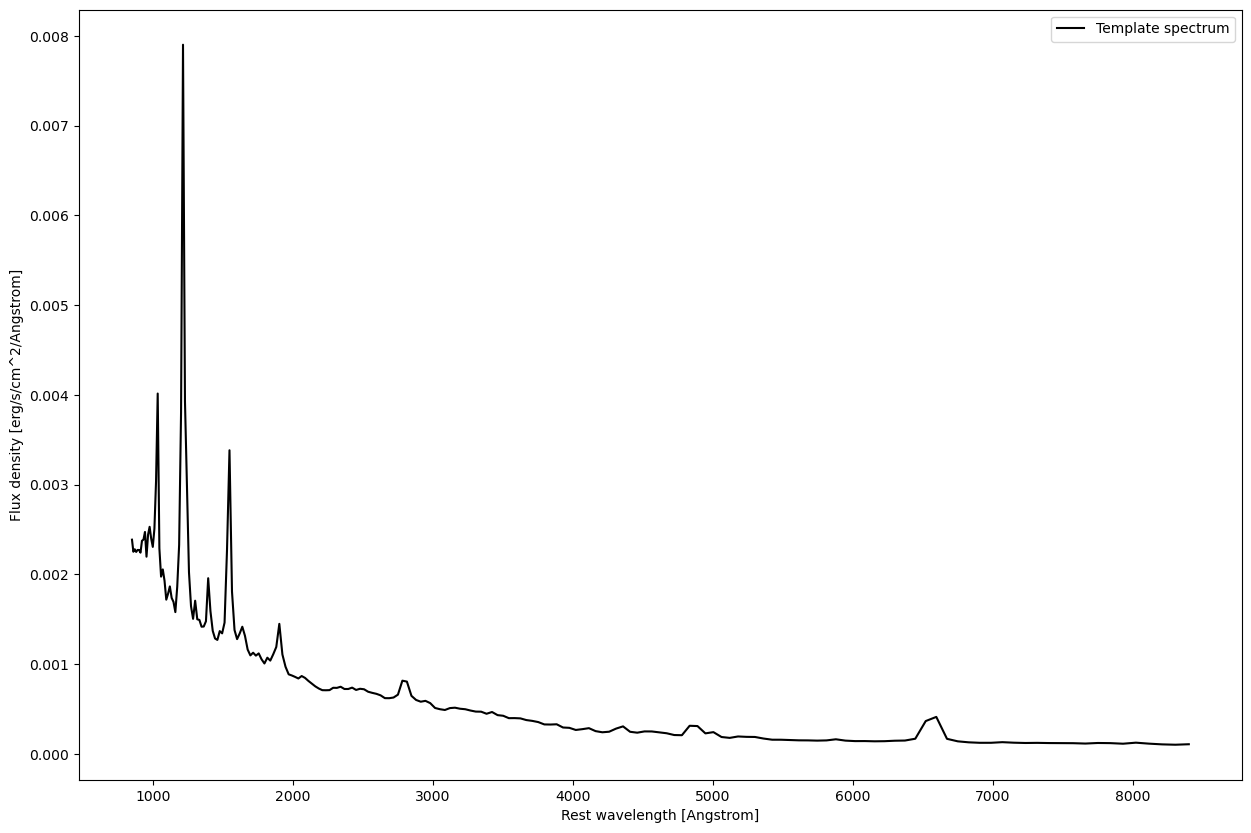

Spectrum Data Object:
name      = Data and Model (Not Best Fit)
x         = Float64[200]
y         = Float64[200]
staterror = None
syserror  = None


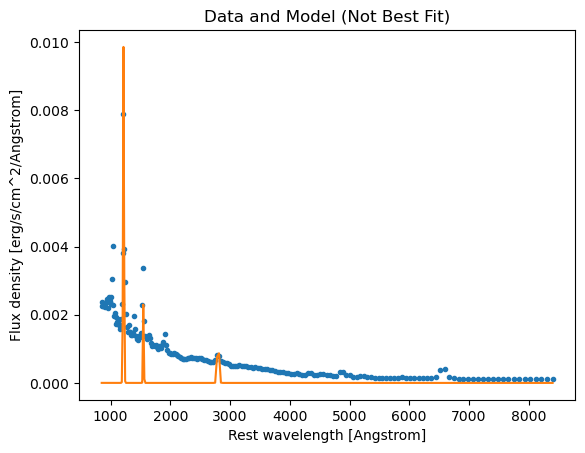

Model Object: 
data      = Data and Model (Not Best Fit)
model     = (((gauss1d + gauss1d) + gauss1d) + powlaw1d)
stat      = LeastSq
method    = LevMar
estmethod = Covariance
Model Result:  True


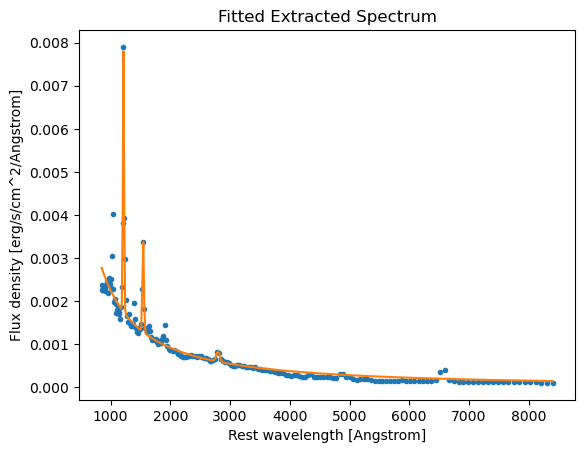

Parameters (after best fit):
('gauss1d.fwhm', 'gauss1d.pos', 'gauss1d.ampl', 'gauss1d.fwhm', 'gauss1d.pos', 'gauss1d.ampl', 'gauss1d.fwhm', 'gauss1d.pos', 'gauss1d.ampl', 'powlaw1d.gamma', 'powlaw1d.ampl')
(23.574389002634994, 1214.74081678135, 0.006059733664551741, 67.54012783972279, 2798.8270298216503, 0.0002504014281416888, 29.28479379766089, 1544.0706032434448, 0.002128559017265994, 1.2918983181210926, 16.89187464486354)


In [2]:
#import packages for spectral modelling - Sherpa
import numpy as np
import matplotlib.pyplot as plt
import sherpa.astro.ui as ui
from sherpa.models.basic import Gauss1D, PowLaw1D
from sherpa.data import Data1D
from sherpa.plot import DataPlot, ModelPlot, FitPlot
from sherpa.stats import LeastSq
from sherpa.optmethods import LevMar, NelderMead
from sherpa.fit import Fit

#create the AGN model - consists of powerlaw and gaussian lines
#note that the AGN model is defined in units of wavelengths (angstroms)
#later we will define the AGN model in keV to match our ARF and RMF files

#create the power law continuum model
#set initial photon index of power law to 2
powerlaw = PowLaw1D()
powerlaw.gamma = 2.0

#create the Gaussian line models
#lyman alpha emission line taken at rest wavelength
lyman_alpha = Gauss1D()
lyman_alpha.pos = 1215.67       #Lyman alpha position
lyman_alpha.ampl = 100/10000    #Lyman alpha amplitude
lyman_alpha.fwhm = 19.46        #Lyman alpha FWHM

#Mg[II] emission line taken at rest wavelength
mg_ii = Gauss1D()
mg_ii.pos = 2798.75             #Magnesium II position
mg_ii.ampl = 14.725/10000       #Magnesium II amplitude
mg_ii.fwhm = 34.95              #Magnesium II FWHM

#C[IV] emission line taken at rest wavelength
c_iv = Gauss1D()
c_iv.pos = 1549.06             #Carbon IV position
c_iv.ampl = 25.291/10000       #Carbon IV amplitude
c_iv.fwhm = 14.33              #Carbon IV FWHM

#define the model 
#final model contains all emission lines present in AGN source 
#emission lines are added to the powerlaw
model = lyman_alpha + mg_ii + c_iv + powerlaw

#load template spectrum
template_spectrum_path = "shang_etal_2011_figure6_flambdaunits.dat"

#first column is the wavelength
#second column is the flux
wave = np.loadtxt(template_spectrum_path, skiprows=1, usecols=0)  ## wavelength [Angstrom] or [A]
flambda = np.loadtxt(template_spectrum_path, skiprows=1, usecols=1)  ## flux density [erg/s/cm^2/A]

#plot the data - template spectrum 
fig1 = plt.figure(figsize=(15,10))
plt.xlabel('Rest wavelength [Angstrom]')
plt.ylabel('Flux density [erg/s/cm^2/Angstrom]')
plt.plot(wave, flambda, color='k', ls='-', label='Template spectrum')
plt.legend(loc='best')
plt.show()

#create a data object that pertains to the above template spectrum
data = Data1D('Data and Model (Not Best Fit)', wave, flambda)
print("Spectrum Data Object:")
print(data)

#create data plot
dplot = DataPlot()
dplot.prepare(data)

#create model plot
mplot = ModelPlot()
mplot.prepare(data, model)

#plot model and data on same graph
dplot.plot()
mplot.overplot()
plt.xlabel('Rest wavelength [Angstrom]')
plt.ylabel('Flux density [erg/s/cm^2/Angstrom]')
plt.title('Data and Model (Not Best Fit)')
plt.show()

#least-square statistic is used
stat = LeastSq()
#optimiser is the part that determines how to minimise the statistic value
#Levenberg-Marquardt (LevMar) is used
opt = LevMar()

#fit the data using the chosen statistic and optimizer method
#best fit of the data set is determined when the least square stat is minimized 
modelfit = Fit(data, model, stat=stat, method=opt)
print("Model Object: ")
print(modelfit)
modelres = modelfit.fit()
print("Model Result: ", modelres.succeeded)

#plot the fit 
fplot = FitPlot()
mplot.prepare(data, model)
fplot.prepare(dplot, mplot)
fplot.plot()
plt.xlabel('Rest wavelength [Angstrom]')
plt.ylabel('Flux density [erg/s/cm^2/Angstrom]')
plt.title("Fitted Extracted Spectrum")
plt.show()

#print the fitted parameters and values
print("Parameters (after best fit):")
print(modelres.parnames)
print(modelres.parvals)


In [3]:
#import necessary packages 
from sherpa.astro.instrument import ARFModelNoPHA, RMFModelNoPHA
from astropy import units as u
from astropy.io import fits
from sherpa.astro.data import DataARF, DataRMF

#create AGN model in keV

#create the power law continuum model
#set initial photon index of power law to 2
powerlaw = PowLaw1D()
powerlaw.gamma = -1.5

#rest wavelengths of gaussian line models (nm)
#need to convert to keV as ARF and RMF are in keV
lyman_wave = 121.567    
lyman_eV = (lyman_wave * u.nm).to(u.eV, equivalencies=u.spectral())
lyman_keV = (lyman_eV.value)/1000
 
mg_wave = 279.875
mg_eV = (mg_wave * u.nm).to(u.eV, equivalencies=u.spectral())
mg_keV = (mg_eV.value)/1000
 
c_wave = 154.906
c_eV = (c_wave * u.nm).to(u.eV, equivalencies=u.spectral())
c_keV = (c_eV.value)/1000
 
#create the Gaussian line models
#lyman alpha emission line taken at rest wavelength
#relative amplitudes are taken from Vandeberk
lyman_alpha = Gauss1D()
lyman_alpha.pos = lyman_keV         #Lyman alpha position (keV)
lyman_alpha.ampl = 100/10000        #Lyman alpha amplitude
lyman_alpha.fwhm = 19.46/100000     #Lyman alpha FWHM

#Mg[II] emission line taken at rest wavelength
mg_ii = Gauss1D()
mg_ii.pos = mg_keV                 #Magnesium II position (keV)
mg_ii.ampl = 14.725/10000          #Magnesium II amplitude
mg_ii.fwhm = 34.95/100000          #Magnesium II FWHM

#C[IV] emission line taken at rest wavelength
c_iv = Gauss1D()
c_iv.pos = c_keV                   #Carbon IV position (keV)
c_iv.ampl = 25.291/10000           #Carbon IV amplitude 
c_iv.fwhm = 14.33/100000           #Carbon IV FWHM

#define the model 
#final model contains all emission lines present in AGN source 
#emission lines are added to the powerlaw
model = lyman_alpha + mg_ii + c_iv + powerlaw

### Next Steps (Tochi)

We need to generate fake spectra to fit our model to. Please note that the fake spectra will not resemble the type of spectra files we will recieve from the CASTOR telescope because we have not incorporated the RMF and ARF file just yet. It is important to gain an understanding first of how generating simple fake spectra in Sherpa works, then we can add in the instrumentation files. 

Steps: 

1. Download your FITS file from your google colab notebook and save it in your environment that contains Sherpa and Astropy. 

2. Open your FITS file, specifically opening the columns with the flambda and keV values. Those will be your data arrays. 

3. Load the flambda and keV arrays that you obtained from your FITS file, using sherpa.ui.load_arrays(id, args). Make sure to indicate an identifier for your dataset as you will be using it throughout your code. (https://sherpa.readthedocs.io/en/4.15.1/ui/api/sherpa.ui.load_arrays.html?highlight=load_array) 

4. After you have defined your dataset, and you already have a defined model (called AGN_model in the above cell), we can start generating a fake dataset. Figure out whether or not you need use sherpa.astro.ui.set_model(id, model=None), to set the source model expression for a data set, before you can use sherpa.ui.fake(id=None, method=<function poisson_noise>). You may run into an error if you do not use set_model before you use the fake function - so it is always a good idea to double check. 
    (https://sherpa.readthedocs.io/en/4.15.1/ui/api/sherpa.astro.ui.set_model.html?highlight=set_model)

    (https://sherpa.readthedocs.io/en/4.15.1/ui/api/sherpa.ui.fake.html?highlight=fake) 
    
5. Now you can try using sherpa.ui.fake(id=None, method=<function poisson_noise>) to simulate fake spectra within Sherpa itself. This function takes your dataset and applies the model to each energy value. Note, if you run into errors at this step, here is an alternative method to try. Instead of using your FITS file to define as a dataset, we will create an energy dataset comprising of one array. To do this, you will need the min and max energies in keV (let us define an energy dataset ranging from 0.003 to 0.009 keV, with a total of 200 bins - I will leave this to you on how you want to do this but a hint would be to check out numpy.arange). Then you would load this array using sherpa.ui.load_arrays as you did above, however this time you will only have one array (the energy array). Then go through Step 4 and 5 and see if you are now able to successfully use the fake function in Sherpa. If you are still running into issues at this part, please reach out on Slack with a screenshot of your issue. 
    
6. Once you are able to generate fake spectra in Sherpa using the fake function, try plotting multiple fake spectra - use the Sherpa documentation page to see how to do this - https://sherpa.readthedocs.io/en/4.15.1/index.html. Does the overall shape of the fake spectra look the same? What are some potential differences you see and why? 

#### Reach out to me on Slack if you have any questions :) 